In [7]:
# 필요한 라이브러리 설치 (주피터 노트북 환경이라면 주석 해제 후 실행)
# !pip install pandas matplotlib transformers

import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import os
import re

# config.yaml에 명시된 경로와 모델명 사용
DATA_PATH = '../data/'
TRAIN_FILE = os.path.join(DATA_PATH, 'train.csv')
MODEL_NAME = 'digit82/kobart-summarization'

print(f"✅ 데이터 경로: {TRAIN_FILE}")
print(f"✅ 분석 모델: {MODEL_NAME}")

✅ 데이터 경로: ../data/train.csv
✅ 분석 모델: digit82/kobart-summarization


In [8]:
# 2.1 데이터 로드
try:
    df_train = pd.read_csv(TRAIN_FILE)
    print(f"\n✅ train 데이터 로드 성공 (총 {len(df_train)}건)")
    print("-" * 50)
    print("📌 상위 3개 데이터 샘플:")
    print(df_train.head(3).to_markdown(index=False))
except FileNotFoundError:
    print(f"\n❌ 오류: '{TRAIN_FILE}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    
# 2.2 토크나이저 로드 (길이 분석의 정확성을 위해)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 2.3 토큰 길이 계산 함수
def get_token_length(text):
    """지정된 토크나이저로 토큰 길이를 계산합니다."""
    # [CLS], [SEP] 같은 특수 토큰도 포함된 길이
    return len(tokenizer.encode(str(text)))


✅ train 데이터 로드 성공 (총 12457건)
--------------------------------------------------
📌 상위 3개 데이터 샘플:
| fname   | dialogue                                                                                                                                                            | summary                                                                                                                      | topic     |
|:--------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------|:----------|
| train_0 | #Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요?                                                                                  | Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필요성을 안내받고 흡연 습관 개선을 위한 도움을 제안받았습니다. | 건강검진  |
|         | #Person2

/opt/conda/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
print("\n📏 대화 및 요약 토큰 길이 분석 시작...")

# dialogue (인코더 입력) 길이 분석
df_train['dialogue_token_len'] = df_train['dialogue'].apply(get_token_length)
# summary (디코더 출력) 길이 분석
df_train['summary_token_len'] = df_train['summary'].apply(get_token_length)

# 통계 요약
dialogue_stats = df_train['dialogue_token_len'].describe(percentiles=[.95, .99])
summary_stats = df_train['summary_token_len'].describe(percentiles=[.95, .99])

print("\n--- 대화(Dialogue) 길이 통계 (토큰 기준) ---")
print(dialogue_stats.to_markdown())

print("\n--- 요약(Summary) 길이 통계 (토큰 기준) ---")
print(summary_stats.to_markdown())


📏 대화 및 요약 토큰 길이 분석 시작...

--- 대화(Dialogue) 길이 통계 (토큰 기준) ---
|       |   dialogue_token_len |
|:------|---------------------:|
| count |           12457      |
| mean  |             199.562  |
| std   |              93.1237 |
| min   |              42      |
| 50%   |             183      |
| 95%   |             358      |
| 99%   |             524      |
| max   |            1079      |

--- 요약(Summary) 길이 통계 (토큰 기준) ---
|       |   summary_token_len |
|:------|--------------------:|
| count |          12457      |
| mean  |             39.972  |
| std   |             15.1499 |
| min   |              6      |
| 50%   |             37      |
| 95%   |             69      |
| 99%   |             87      |
| max   |            161      |


In [10]:
# 4.1 노이즈 패턴 정의
# 대회 설명에 있던 \n, <br> 등의 노이즈 패턴을 확인
NOISE_PATTERNS = {
    '\\n': '이스케이프된 뉴라인 (\\n)',
    '<br>': 'HTML 태그 뉴라인 (<br>)',
    '#Person': '발화자 표기',
    '\n': '일반 뉴라인 (\\n)'
}

# 4.2 노이즈 포함 건수 계산
noise_data = {}
total_samples = len(df_train)

for pattern, name in NOISE_PATTERNS.items():
    # re.escape를 사용하여 특수문자를 정확히 찾도록 함
    count = df_train['dialogue'].astype(str).str.contains(re.escape(pattern), regex=True).sum()
    if pattern in ('\\n', '<br>'): # 핵심 노이즈만 퍼센트로 출력
        print(f"🔥 {name} 포함 건수: {count}건 ({count / total_samples * 100:.2f}%)")
    noise_data[name] = count

print("-" * 50)

# 4.3 노이즈 포함 데이터 샘플 확인 (전처리가 필요한지 눈으로 확인)
noise_samples = df_train[df_train['dialogue'].astype(str).str.contains(re.escape('\\n')) | 
                         df_train['dialogue'].astype(str).str.contains(re.escape('<br>'))].head(2)

print("📌 노이즈 포함 대화 샘플:")
for i, row in noise_samples.iterrows():
    print(f"\n--- fname: {row['fname']} ---")
    print(f"원본 대화: \n{row['dialogue']}")

🔥 이스케이프된 뉴라인 (\n) 포함 건수: 1건 (0.01%)
🔥 HTML 태그 뉴라인 (<br>) 포함 건수: 1건 (0.01%)
--------------------------------------------------
📌 노이즈 포함 대화 샘플:

--- fname: train_129 ---
원본 대화: 
#Person1#: 저, 불만이 있어요. 열 분 동안 테이블에서 기다렸는데, 웨이터가 드디어 와서 주문을 받았어요. 그런데 나온 음식이 제가 주문한 게 아니더라고요.\n#Person2#: 정말 죄송합니다. 오늘 밤은 평소보다 많이 바빠서요. 보상으로, 오늘 식사는 무료로 하겠습니다.

--- fname: train_8139 ---
원본 대화: 
#Person1#: 요즘 잘 지내고 있어요?<br>#Person2#: 제 코치가 제 혈압을 체크해 달라고 부탁했어요.<br>#Person1#: 전에 고혈압 있다고 들은 적 있나요?<br>#Person2#: 고혈압 증상은 없어요.<br>#Person1#: 고혈압 있는 사람들은 대부분 본인이 모르는 경우가 많아요. 그래서 조용한 살인자라고 부르죠.<br>#Person2#: 고혈압 검사는 어떻게 해요?<br>#Person1#: 이 커프에 공기를 넣어서 측정할 거예요.<br>#Person2#: 측정 후에 어떤 정보를 알 수 있나요?<br>#Person1#: 심장이 얼마나 강하게 피를 펌프하는지와 동맥이 쉴 때 얼마나 이완되는지를 알려줘요.<br>#Person2#: 이번 검사가 잘 됐으면 좋겠어요.


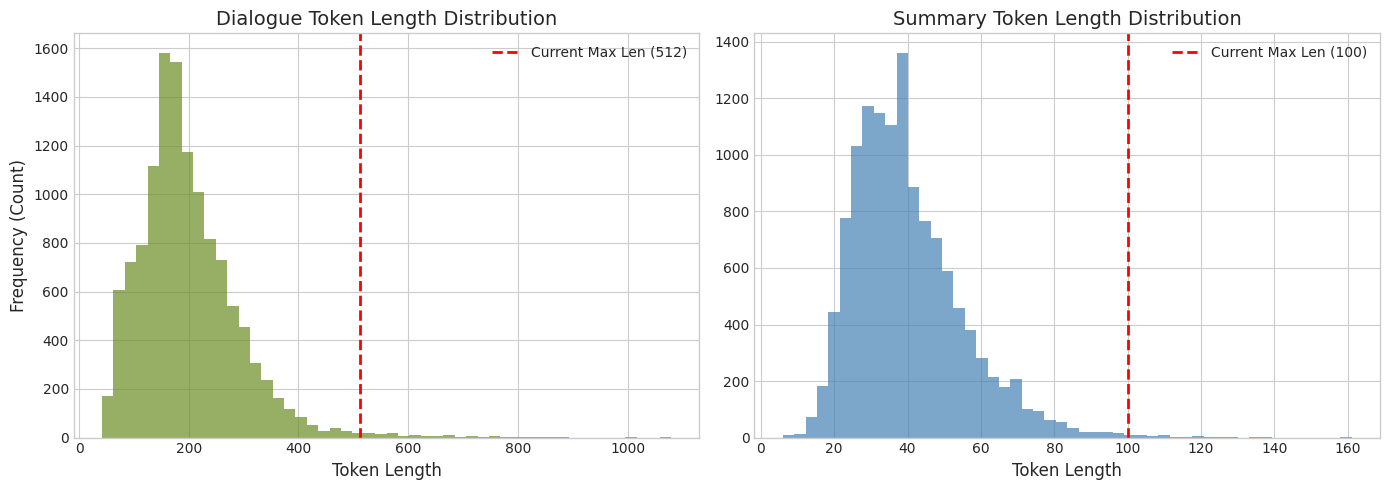


              💡 EDA 결과 기반의 전처리 및 튜닝 조치 계획
🔥 [1순위 조치: 전처리] 노이즈 제거
  - (노이즈는 적은 것으로 보이나, 반드시 샘플 확인 후 모든 줄 바꿈 형태를 통일해야 합니다.)

📏 [2순위 조치: 하이퍼파라미터] 길이 조정
  - 대화 길이 99% 지점: 524 토큰 (현재 512)
  - 요약 길이 99% 지점: 87 토큰 (현재 100)

⚙️ [3순위 조치: 하이퍼파라미터] 학습 설정
  - **다음 실험:** 길이 관련 설정을 수정한 후, `learning_rate` (`1.0e-05` -> `2e-5` 또는 `3e-5`)와 `num_beams` (`4` -> `6` 또는 `8`)를 튜닝해야 합니다.


In [14]:
# 5.1 히스토그램 시각화 (matplotlib)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) 대화 길이 분포 (Encoder)
ax1 = axes[0]
df_train['dialogue_token_len'].hist(bins=50, ax=ax1, color='#6B8E23', alpha=0.7)
# 현재 config 값인 512에 선을 그림
ax1.axvline(x=512, color='r', linestyle='--', linewidth=2, label='Current Max Len (512)')
ax1.set_title('Dialogue Token Length Distribution', fontsize=14)
ax1.set_xlabel('Token Length', fontsize=12)
ax1.set_ylabel('Frequency (Count)', fontsize=12)
ax1.legend()

# (2) 요약 길이 분포 (Decoder)
ax2 = axes[1]
df_train['summary_token_len'].hist(bins=50, ax=ax2, color='#4682B4', alpha=0.7)
# 현재 config 값인 100에 선을 그림
ax2.axvline(x=100, color='r', linestyle='--', linewidth=2, label='Current Max Len (100)')
ax2.set_title('Summary Token Length Distribution', fontsize=14)
ax2.set_xlabel('Token Length', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

# 5.2 최종 해석 및 조치 계획
print("\n" + "=" * 70)
print("              💡 EDA 결과 기반의 전처리 및 튜닝 조치 계획")
print("=" * 70)

# 1. 전처리 (가장 시급)
print("🔥 [1순위 조치: 전처리] 노이즈 제거")
if noise_data.get('\\n', 0) > 0 or noise_data.get('<br>', 0) > 0:
    print("  - **필수:** '{}' 또는 '{}'이 다수 발견되었습니다.".format(NOISE_PATTERNS['\\n'], NOISE_PATTERNS['<br>']))
    print("  - **조치:** `baseline.py`의 전처리 함수에 이 노이즈들을 **하나의 공통된 구분자**로 치환하는 로직을 추가해야 합니다.")
else:
    print("  - (노이즈는 적은 것으로 보이나, 반드시 샘플 확인 후 모든 줄 바꿈 형태를 통일해야 합니다.)")

# 2. 하이퍼파라미터 튜닝 (길이 기반)
print("\n📏 [2순위 조치: 하이퍼파라미터] 길이 조정")
print(f"  - 대화 길이 99% 지점: {dialogue_stats['99%']:.0f} 토큰 (현재 512)")
print(f"  - 요약 길이 99% 지점: {summary_stats['99%']:.0f} 토큰 (현재 100)")
if summary_stats['99%'] > 100:
    print(f"  - **조치:** 요약문의 99%는 {summary_stats['99%']:.0f} 토큰입니다. `generate_max_length`를 **{summary_stats['99%'] + 5:.0f}** 정도로 늘려 요약 잘림을 방지해야 합니다.")
elif summary_stats['max'] < 100:
    print(f"  - **조치:** 요약문의 최대 길이는 {summary_stats['max']:.0f} 토큰입니다. `generate_max_length`를 **{summary_stats['max'] + 5:.0f}** 정도로 줄여 속도를 개선할 수 있습니다.")

# 3. 추가 튜닝 (학습 기반)
print("\n⚙️ [3순위 조치: 하이퍼파라미터] 학습 설정")
print(f"  - **다음 실험:** 길이 관련 설정을 수정한 후, `learning_rate` (`1.0e-05` -> `2e-5` 또는 `3e-5`)와 `num_beams` (`4` -> `6` 또는 `8`)를 튜닝해야 합니다.")